# NOAA GEFS Basin Forecasts and Historical Data

This notebook extracts forecast data for each basin centroid from the NOAA GEFS 35-day forecast dataset, fetches corresponding historical weather data using Open-Meteo, and combines them into a single dataset.

## Overview

The process consists of the following steps:
1. Load basin centroid coordinates from a CSV file
2. Connect to the NOAA GEFS forecast dataset
3. Extract forecast data for each basin location using all available initialization times
4. Compute quartiles (25th, 50th, 75th percentiles) from ensemble forecasts as separate variables
5. Determine the time range based on forecast data
6. Fetch historical weather data for the same basins and time range
7. Interpolate forecast quartiles to hourly resolution
8. Merge the historical and hourly forecast quartile data into a combined dataset
9. Visualize and analyze the combined forecast and historical data
10. Save the combined hourly data to NetCDF files

In [12]:
# Import required libraries
import os
import sys
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings

# Add src directory to path if it's not already in the path
if '../src' not in sys.path:
    sys.path.append('../src')
from fetch_basin_forecasts import (
    load_basin_centroids,
    fetch_forecasts_for_basins,
    interpolate_to_hourly,
)
from fetch_basin_historical import fetch_historical_for_basins # Import the new function

# Suppress warnings
warnings.filterwarnings('ignore')

## Define Paths for Input and Output Data

In [13]:
# Define paths for input and output data
basin_centroids_file = "../data/basin_centroids.csv"  # File containing basin centroid coordinates
output_dir = "../data/basin_data"  # Directory for output data (plots and netcdf)

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

print(f"Basin centroids file: {basin_centroids_file}")
print(f"Output directory: {output_dir}")

Basin centroids file: ../data/basin_centroids.csv
Output directory: ../data/basin_data


## Load Basin Centroids

Load the basin centroid coordinates from the CSV file.

In [14]:
# Load basin centroids
centroids = load_basin_centroids(basin_centroids_file)

# Display the basin coordinates
display(centroids)

Loaded 5 basin centroids from ../data/basin_centroids.csv


,basin_name,latitude,longitude
0,innerste_reservoir_catchment_Basin_0,51.834451,10.307828
1,oker_reservoir_catchment_Basin_0,51.816468,10.447276
2,ecker_reservoir_catchment_Basin_0,51.810056,10.584058
3,soese_reservoir_catchment_Basin_0,51.752310,10.383225
4,grane_reservoir_catchment_Basin_0,51.884391,10.357203


## Load NOAA GEFS Forecast Dataset

Connect to the online NOAA GEFS forecast dataset hosted by dynamical.org.

In [15]:
# Install dependencies if needed
# %pip install "xarray[complete]>=2025.1.2" "zarr>=3.0.4" requests aiohttp

In [16]:
# Load the NOAA GEFS forecast dataset
print("Loading NOAA GEFS dataset...")
ds = xr.open_zarr(
    "https://data.dynamical.org/noaa/gefs/forecast-35-day/latest.zarr?email=optional@email.com", 
    decode_timedelta=True
)

print("\nDataset summary:")
print(f"Time domain: {ds.attrs.get('time_domain', 'N/A')}")
print(f"Forecast domain: {ds.attrs.get('forecast_domain', 'N/A')}")
print(f"Spatial resolution: {ds.attrs.get('spatial_resolution', 'N/A')}")
print(f"\nDataset dimensions:")
for dim, size in ds.dims.items():
    print(f"  {dim}: {size}")

# Show the available initialization times (limited to last 10 for display)
init_times = pd.to_datetime(ds.init_time.values)
print(f"\nTotal number of initialization times: {len(init_times)}")
print(f"First initialization time: {init_times[0].strftime('%Y-%m-%d %H:%M')}")
print(f"Last initialization time: {init_times[-1].strftime('%Y-%m-%d %H:%M')}")

Loading NOAA GEFS dataset...

Dataset summary:
Time domain: Forecasts initialized 2020-10-01 00:00:00 UTC to Present
Forecast domain: Forecast lead time 0-840 hours (0-35 days) ahead
Spatial resolution: 0-240 hours: 0.25 degrees (~20km), 243-840 hours: 0.5 degrees (~40km)

Dataset dimensions:
  init_time: 1700
  ensemble_member: 31
  lead_time: 181
  latitude: 721
  longitude: 1440

Total number of initialization times: 1700
First initialization time: 2020-10-01 00:00
Last initialization time: 2025-05-27 00:00

Dataset summary:
Time domain: Forecasts initialized 2020-10-01 00:00:00 UTC to Present
Forecast domain: Forecast lead time 0-840 hours (0-35 days) ahead
Spatial resolution: 0-240 hours: 0.25 degrees (~20km), 243-840 hours: 0.5 degrees (~40km)

Dataset dimensions:
  init_time: 1700
  ensemble_member: 31
  lead_time: 181
  latitude: 721
  longitude: 1440

Total number of initialization times: 1700
First initialization time: 2020-10-01 00:00
Last initialization time: 2025-05-27 00:

## Extract Forecasts for Basin Centroids

Extract the forecast data for each basin centroid location using all available initialization times.

In [17]:
# Option to limit the number of initialization times for testing or specific analysis
# Uncomment and modify the code below to use specific initialization times

# Use the most recent 5 initialization times to speed up processing
# recent_times = ds.init_time.values[-5:]
# ds_limited = ds.sel(init_time=recent_times)
# print(f"Limited analysis to the {len(recent_times)} most recent initialization times")

# Use all available initialization times for comprehensive analysis
# Set init_time to None to use all available times
init_time = None

# Extract forecasts for all basin centroids
basin_forecasts = fetch_forecasts_for_basins(ds, centroids, init_time)

# Check how many basin forecasts we've extracted
print(f"\nExtracted forecasts for {len(basin_forecasts)} basins")

Extracting forecasts for 5 basins...
Processing basin: innerste_reservoir_catchment_Basin_0 (lat: 51.8345, lon: 10.3078)
Processing basin: oker_reservoir_catchment_Basin_0 (lat: 51.8165, lon: 10.4473)
Processing basin: ecker_reservoir_catchment_Basin_0 (lat: 51.8101, lon: 10.5841)
Processing basin: soese_reservoir_catchment_Basin_0 (lat: 51.7523, lon: 10.3832)
Processing basin: ecker_reservoir_catchment_Basin_0 (lat: 51.8101, lon: 10.5841)
Processing basin: soese_reservoir_catchment_Basin_0 (lat: 51.7523, lon: 10.3832)
Processing basin: grane_reservoir_catchment_Basin_0 (lat: 51.8844, lon: 10.3572)
Processing basin: grane_reservoir_catchment_Basin_0 (lat: 51.8844, lon: 10.3572)
Successfully extracted forecasts for 5 basins
Dataset dimensions: {'basin': 5, 'init_time': 1700, 'ensemble_member': 31, 'lead_time': 181}

Extracted forecasts for 21 basins
Successfully extracted forecasts for 5 basins
Dataset dimensions: {'basin': 5, 'init_time': 1700, 'ensemble_member': 31, 'lead_time': 181}


In [18]:
basin_forecasts

<xarray.Dataset> Size: 4GB
Dimensions:                                     (basin: 5, init_time: 1700,
                                                 ensemble_member: 31,
                                                 lead_time: 181)
Coordinates:
  * ensemble_member                             (ensemble_member) uint16 62B ...
    expected_forecast_length                    (init_time) timedelta64[ns] 14kB dask.array<chunksize=(1700,), meta=np.ndarray>
    ingested_forecast_length                    (init_time, ensemble_member) timedelta64[ns] 422kB dask.array<chunksize=(1700, 31), meta=np.ndarray>
  * init_time                                   (init_time) datetime64[ns] 14kB ...
    latitude                                    (basin) float64 40B 51.75 ......
  * lead_time                                   (lead_time) timedelta64[ns] 1kB ...
    longitude                                   (basin) float64 40B 10.25 ......
    spatial_ref                                 int64 8B ...
    valid_time                                  (init_time, lead_time) datetime64[ns] 2MB dask.array<chunksize=(1700, 181), meta=np.ndarray>
  * basin                                       (basin) <U36 720B 'innerste_r...
Data variables: (12/21)
    categorical_freezing_rain_surface           (basin, init_time, ensemble_member, lead_time) float32 191MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    categorical_ice_pellets_surface             (basin, init_time, ensemble_member, lead_time) float32 191MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    categorical_rain_surface                    (basin, init_time, ensemble_member, lead_time) float32 191MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    categorical_snow_surface                    (basin, init_time, ensemble_member, lead_time) float32 191MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    downward_long_wave_radiation_flux_surface   (basin, init_time, ensemble_member, lead_time) float32 191MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    downward_short_wave_radiation_flux_surface  (basin, init_time, ensemble_member, lead_time) float32 191MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    ...                                          ...
    temperature_2m                              (basin, init_time, ensemble_member, lead_time) float32 191MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    total_cloud_cover_atmosphere                (basin, init_time, ensemble_member, lead_time) float32 191MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    wind_u_100m                                 (basin, init_time, ensemble_member, lead_time) float32 191MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    wind_u_10m                                  (basin, init_time, ensemble_member, lead_time) float32 191MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    wind_v_100m                                 (basin, init_time, ensemble_member, lead_time) float32 191MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    wind_v_10m                                  (basin, init_time, ensemble_member, lead_time) float32 191MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
Attributes:
    dataset_id:           noaa-gefs-forecast-35-day
    dataset_version:      0.2.0
    name:                 NOAA GEFS forecast, 35 day
    description:          Weather forecasts from the Global Ensemble Forecast...
    attribution:          NOAA NWS NCEP GEFS data processed by dynamical.org ...
    spatial_domain:       Global
    spatial_resolution:   0-240 hours: 0.25 degrees (~20km), 243-840 hours: 0...
    time_domain:          Forecasts initialized 2020-10-01 00:00:00 UTC to Pr...
    time_resolution:      Forecasts initialized every 24 hours.
    forecast_domain:      Forecast lead time 0-840 hours (0-35 days) ahead
    forecast_resolution:  Forecast step 0-240 hours: 3 hourly, 243-840 hours:...

## Compute Forecast Quartiles as Separate Variables

Convert ensemble forecasts to quartiles (25th, 50th, 75th percentiles) as separate variables to reduce data size while preserving key statistical information. Each original variable will result in three new variables with suffixes _q25, _q50, and _q75.

In [19]:
def compute_forecast_quartiles_as_variables(forecast_ds, quartiles=[0.25, 0.5, 0.75]):
    """
    Compute quartiles from ensemble forecast data as separate variables.
    
    Parameters:
    -----------
    forecast_ds : xarray.Dataset
        Dataset with ensemble_member dimension
    quartiles : list
        List of quantiles to compute (default: [0.25, 0.5, 0.75])
    
    Returns:
    --------
    xarray.Dataset
        Dataset with separate variables for each quartile, without ensemble_member dimension
    """
    print(f"Computing quartiles {quartiles} from ensemble forecasts as separate variables...")
    
    # Define quartile suffixes
    quartile_suffixes = {
        0.25: '_q25',
        0.5: '_q50', 
        0.75: '_q75'
    }
    
    # Create new dataset with quartile variables
    new_data_vars = {}
    
    # Process each data variable
    for var_name in forecast_ds.data_vars:
        print(f"Processing variable: {var_name}")
        var_data = forecast_ds[var_name]
        
        # Compute quartiles for this variable
        var_quartiles = var_data.quantile(quartiles, dim='ensemble_member')
        
        # Create separate variables for each quartile
        for i, q in enumerate(quartiles):
            suffix = quartile_suffixes.get(q, f'_q{int(q*100)}')
            new_var_name = f"{var_name}{suffix}"
            
            # Extract the quartile data (remove the quantile dimension)
            quartile_data = var_quartiles.isel(quantile=i).drop('quantile')
            
            # Add to new data variables
            new_data_vars[new_var_name] = quartile_data
    
    # Create new dataset with the same coordinates (excluding ensemble_member)
    coords_to_keep = {k: v for k, v in forecast_ds.coords.items() if 'ensemble_member' not in v.dims}
    
    # Create the new dataset
    quartile_ds = xr.Dataset(
        data_vars=new_data_vars,
        coords=coords_to_keep,
        attrs=forecast_ds.attrs.copy()
    )
    
    # Update attributes
    quartile_ds.attrs['quartile_processing'] = f'Computed quartiles {quartiles} as separate variables'
    quartile_ds.attrs['original_ensemble_members'] = len(forecast_ds.ensemble_member)
    
    print(f"Original dataset dimensions: {dict(forecast_ds.dims)}")
    print(f"Quartile dataset dimensions: {dict(quartile_ds.dims)}")
    print(f"Original variables: {len(forecast_ds.data_vars)}")
    print(f"New quartile variables: {len(quartile_ds.data_vars)}")
    
    return quartile_ds

# Apply quartile computation to basin forecasts
basin_forecasts_quartiles = compute_forecast_quartiles_as_variables(basin_forecasts)

# Display the quartile dataset
basin_forecasts_quartiles

Computing quartiles [0.25, 0.5, 0.75] from ensemble forecasts as separate variables...
Processing variable: categorical_freezing_rain_surface
Processing variable: categorical_ice_pellets_surface
Processing variable: categorical_rain_surface
Processing variable: categorical_snow_surface
Processing variable: downward_long_wave_radiation_flux_surface
Processing variable: categorical_snow_surface
Processing variable: downward_long_wave_radiation_flux_surface
Processing variable: downward_short_wave_radiation_flux_surface
Processing variable: geopotential_height_cloud_ceiling
Processing variable: downward_short_wave_radiation_flux_surface
Processing variable: geopotential_height_cloud_ceiling
Processing variable: maximum_temperature_2m
Processing variable: minimum_temperature_2m
Processing variable: maximum_temperature_2m
Processing variable: minimum_temperature_2m
Processing variable: percent_frozen_precipitation_surface
Processing variable: percent_frozen_precipitation_surface
Processing 

<xarray.Dataset> Size: 778MB
Dimensions:                                         (init_time: 1700, basin: 5,
                                                     lead_time: 181)
Coordinates:
    expected_forecast_length                        (init_time) timedelta64[ns] 14kB dask.array<chunksize=(1700,), meta=np.ndarray>
  * init_time                                       (init_time) datetime64[ns] 14kB ...
    latitude                                        (basin) float64 40B 51.75...
  * lead_time                                       (lead_time) timedelta64[ns] 1kB ...
    longitude                                       (basin) float64 40B 10.25...
    valid_time                                      (init_time, lead_time) datetime64[ns] 2MB dask.array<chunksize=(1700, 181), meta=np.ndarray>
  * basin                                           (basin) <U36 720B 'inners...
    spatial_ref                                     int64 8B ...
Data variables: (12/63)
    categorical_freezing_rain_surface_q25           (basin, init_time, lead_time) float64 12MB dask.array<chunksize=(1, 1, 64), meta=np.ndarray>
    categorical_freezing_rain_surface_q50           (basin, init_time, lead_time) float64 12MB dask.array<chunksize=(1, 1, 64), meta=np.ndarray>
    categorical_freezing_rain_surface_q75           (basin, init_time, lead_time) float64 12MB dask.array<chunksize=(1, 1, 64), meta=np.ndarray>
    categorical_ice_pellets_surface_q25             (basin, init_time, lead_time) float64 12MB dask.array<chunksize=(1, 1, 64), meta=np.ndarray>
    categorical_ice_pellets_surface_q50             (basin, init_time, lead_time) float64 12MB dask.array<chunksize=(1, 1, 64), meta=np.ndarray>
    categorical_ice_pellets_surface_q75             (basin, init_time, lead_time) float64 12MB dask.array<chunksize=(1, 1, 64), meta=np.ndarray>
    ...                                              ...
    wind_v_100m_q25                                 (basin, init_time, lead_time) float64 12MB dask.array<chunksize=(1, 1, 64), meta=np.ndarray>
    wind_v_100m_q50                                 (basin, init_time, lead_time) float64 12MB dask.array<chunksize=(1, 1, 64), meta=np.ndarray>
    wind_v_100m_q75                                 (basin, init_time, lead_time) float64 12MB dask.array<chunksize=(1, 1, 64), meta=np.ndarray>
    wind_v_10m_q25                                  (basin, init_time, lead_time) float64 12MB dask.array<chunksize=(1, 1, 64), meta=np.ndarray>
    wind_v_10m_q50                                  (basin, init_time, lead_time) float64 12MB dask.array<chunksize=(1, 1, 64), meta=np.ndarray>
    wind_v_10m_q75                                  (basin, init_time, lead_time) float64 12MB dask.array<chunksize=(1, 1, 64), meta=np.ndarray>
Attributes: (12/13)
    dataset_id:                 noaa-gefs-forecast-35-day
    dataset_version:            0.2.0
    name:                       NOAA GEFS forecast, 35 day
    description:                Weather forecasts from the Global Ensemble Fo...
    attribution:                NOAA NWS NCEP GEFS data processed by dynamica...
    spatial_domain:             Global
    ...                         ...
    time_domain:                Forecasts initialized 2020-10-01 00:00:00 UTC...
    time_resolution:            Forecasts initialized every 24 hours.
    forecast_domain:            Forecast lead time 0-840 hours (0-35 days) ahead
    forecast_resolution:        Forecast step 0-240 hours: 3 hourly, 243-840 ...
    quartile_processing:        Computed quartiles [0.25, 0.5, 0.75] as separ...
    original_ensemble_members:  31

## Plot Forecast Quartiles Before Interpolation

Visualize the quartiles of the forecast for a specific basin before interpolation.

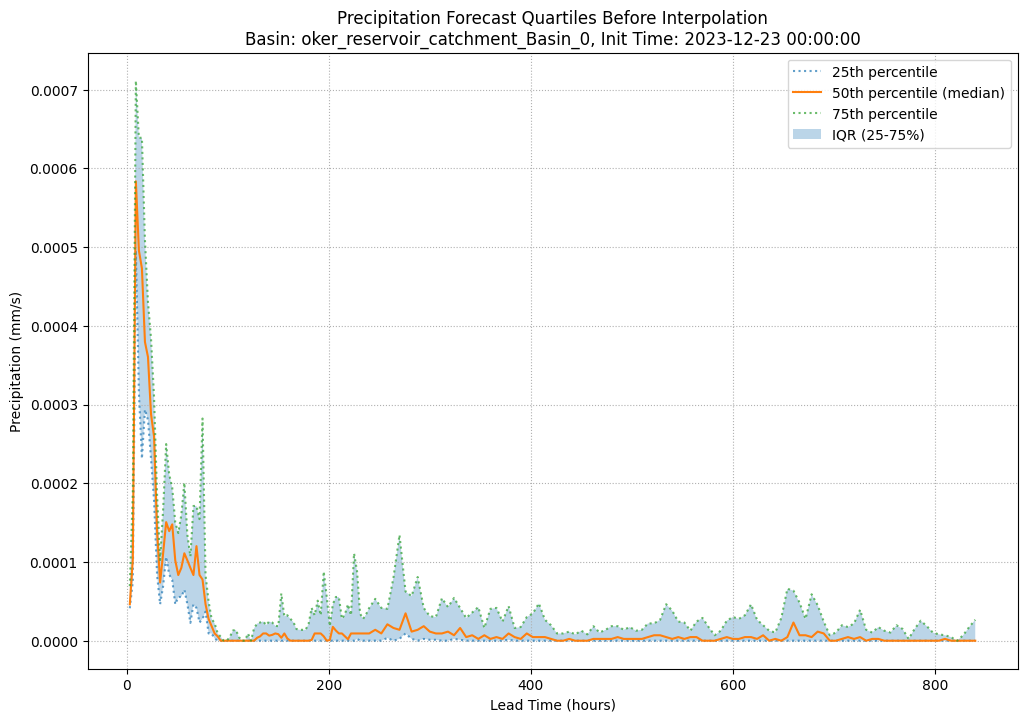

In [21]:
# Select a specific forecast initialization time and basin
forecast_init_time = '2023-12-23 00:00:00'
selected_basin = 'oker_reservoir_catchment_Basin_0'

# Extract the forecast dataset for the selected basin and initialization time
plot_ds = basin_forecasts_quartiles.sel(init_time=forecast_init_time, basin=selected_basin)

# Convert lead_time from timedelta to hours for plotting
lead_time_hours = plot_ds['lead_time'].values / np.timedelta64(1, 'h')

# Plot the quartiles for precipitation before interpolation
plt.figure(figsize=(12, 8))

# Plot the three quartiles
plt.plot(lead_time_hours, plot_ds['precipitation_surface_q25'], label='25th percentile', linestyle=':', alpha=0.7)
plt.plot(lead_time_hours, plot_ds['precipitation_surface_q50'], label='50th percentile (median)', linestyle='-')
plt.plot(lead_time_hours, plot_ds['precipitation_surface_q75'], label='75th percentile', linestyle=':', alpha=0.7)

# Fill between 25th and 75th percentiles
plt.fill_between(lead_time_hours, plot_ds['precipitation_surface_q25'], plot_ds['precipitation_surface_q75'], alpha=0.3, label='IQR (25-75%)')

plt.title(f'Precipitation Forecast Quartiles Before Interpolation\nBasin: {selected_basin}, Init Time: {forecast_init_time}')
plt.xlabel('Lead Time (hours)')
plt.ylabel('Precipitation (mm/s)')
plt.legend()
plt.grid(True, linestyle=':')
plt.show()

## Interpolate Forecast Quartiles to Hourly Resolution

The NOAA GEFS forecast dataset provides data at varying temporal resolutions:
- For the first 240 hours (10 days): Data is available at 3-hour intervals
- For hours 243-840 (days 11-35): Data is available at 6-hour intervals

This results in 181 lead time steps over the 35-day forecast period.

We interpolate the forecast quartile values to hourly resolution for the first 10 days (240 hours) using linear interpolation. This provides higher temporal granularity for merging with hourly historical data.

In [22]:
# Apply linear interpolation to convert forecast quartile data to hourly resolution for the first 10 days
print("Interpolating forecast quartile data to hourly resolution for the first 10 days...")

# Process the dataset to get hourly resolution
basin_forecasts_quartiles_hourly = interpolate_to_hourly(basin_forecasts_quartiles, max_hours=240) # 10 days = 240 hours

# Show the new dataset's time dimension
print(f"\nOriginal forecast lead_times: {len(basin_forecasts_quartiles.lead_time)} steps")
print(f"Hourly forecast lead_times: {len(basin_forecasts_quartiles_hourly.lead_time)} steps")

# Compare the resolution before and after
print("\nOriginal forecast lead_time resolution (first 24 hours):")
print(basin_forecasts_quartiles.lead_time[:9].values)

print("\nNew hourly forecast lead_time resolution (first 24 hours):")
print(basin_forecasts_quartiles_hourly.lead_time[:25].values)

# Compare dataset dimensions
print(f"\nOriginal forecast dimensions: {dict(basin_forecasts_quartiles.dims)}")
print(f"Hourly forecast dimensions: {dict(basin_forecasts_quartiles_hourly.dims)}")

# Show sample variable names
sample_vars = list(basin_forecasts_quartiles_hourly.data_vars)[:6]
print(f"\nSample quartile variables: {sample_vars}")

# Preview the hourly forecast dataset
basin_forecasts_quartiles_hourly

Interpolating forecast quartile data to hourly resolution for the first 10 days...

Original forecast lead_times: 181 steps
Hourly forecast lead_times: 240 steps

Original forecast lead_time resolution (first 24 hours):
[             0 10800000000000 21600000000000 32400000000000
 43200000000000 54000000000000 64800000000000 75600000000000
 86400000000000]

New hourly forecast lead_time resolution (first 24 hours):
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]

Original forecast dimensions: {'init_time': 1700, 'basin': 5, 'lead_time': 181}
Hourly forecast dimensions: {'init_time': 1700, 'basin': 5, 'lead_time': 240}

Sample quartile variables: ['categorical_freezing_rain_surface_q25', 'categorical_freezing_rain_surface_q50', 'categorical_freezing_rain_surface_q75', 'categorical_ice_pellets_surface_q25', 'categorical_ice_pellets_surface_q50', 'categorical_ice_pellets_surface_q75']

Original forecast lead_times: 181 steps
Hourly forecast lead_times: 240 st

<xarray.Dataset> Size: 1GB
Dimensions:                                         (init_time: 1700, basin: 5,
                                                     lead_time: 240)
Coordinates:
    expected_forecast_length                        (init_time) timedelta64[ns] 14kB dask.array<chunksize=(1700,), meta=np.ndarray>
  * init_time                                       (init_time) datetime64[ns] 14kB ...
    latitude                                        (basin) float64 40B 51.75...
    longitude                                       (basin) float64 40B 10.25...
  * basin                                           (basin) <U36 720B 'inners...
    spatial_ref                                     int64 8B ...
  * lead_time                                       (lead_time) int64 2kB 1 ....
Data variables: (12/63)
    categorical_freezing_rain_surface_q25           (basin, init_time, lead_time) float64 16MB dask.array<chunksize=(1, 1, 240), meta=np.ndarray>
    categorical_freezing_rain_surface_q50           (basin, init_time, lead_time) float64 16MB dask.array<chunksize=(1, 1, 240), meta=np.ndarray>
    categorical_freezing_rain_surface_q75           (basin, init_time, lead_time) float64 16MB dask.array<chunksize=(1, 1, 240), meta=np.ndarray>
    categorical_ice_pellets_surface_q25             (basin, init_time, lead_time) float64 16MB dask.array<chunksize=(1, 1, 240), meta=np.ndarray>
    categorical_ice_pellets_surface_q50             (basin, init_time, lead_time) float64 16MB dask.array<chunksize=(1, 1, 240), meta=np.ndarray>
    categorical_ice_pellets_surface_q75             (basin, init_time, lead_time) float64 16MB dask.array<chunksize=(1, 1, 240), meta=np.ndarray>
    ...                                              ...
    wind_v_100m_q25                                 (basin, init_time, lead_time) float64 16MB dask.array<chunksize=(1, 1, 240), meta=np.ndarray>
    wind_v_100m_q50                                 (basin, init_time, lead_time) float64 16MB dask.array<chunksize=(1, 1, 240), meta=np.ndarray>
    wind_v_100m_q75                                 (basin, init_time, lead_time) float64 16MB dask.array<chunksize=(1, 1, 240), meta=np.ndarray>
    wind_v_10m_q25                                  (basin, init_time, lead_time) float64 16MB dask.array<chunksize=(1, 1, 240), meta=np.ndarray>
    wind_v_10m_q50                                  (basin, init_time, lead_time) float64 16MB dask.array<chunksize=(1, 1, 240), meta=np.ndarray>
    wind_v_10m_q75                                  (basin, init_time, lead_time) float64 16MB dask.array<chunksize=(1, 1, 240), meta=np.ndarray>
Attributes: (12/17)
    dataset_id:                 noaa-gefs-forecast-35-day
    dataset_version:            0.2.0
    name:                       NOAA GEFS forecast, 35 day
    description:                Weather forecasts from the Global Ensemble Fo...
    attribution:                NOAA NWS NCEP GEFS data processed by dynamica...
    spatial_domain:             Global
    ...                         ...
    quartile_processing:        Computed quartiles [0.25, 0.5, 0.75] as separ...
    original_ensemble_members:  31
    interpolation:              Linear interpolation to hourly resolution
    original_resolution:        3-hourly for first 10 days
    max_forecast_hours:         240
    lead_time_format:           Integer hours from 1 to 240

## Plot Forecast Quartiles After Interpolation

Visualize the quartiles of the forecast for a specific basin after interpolation.

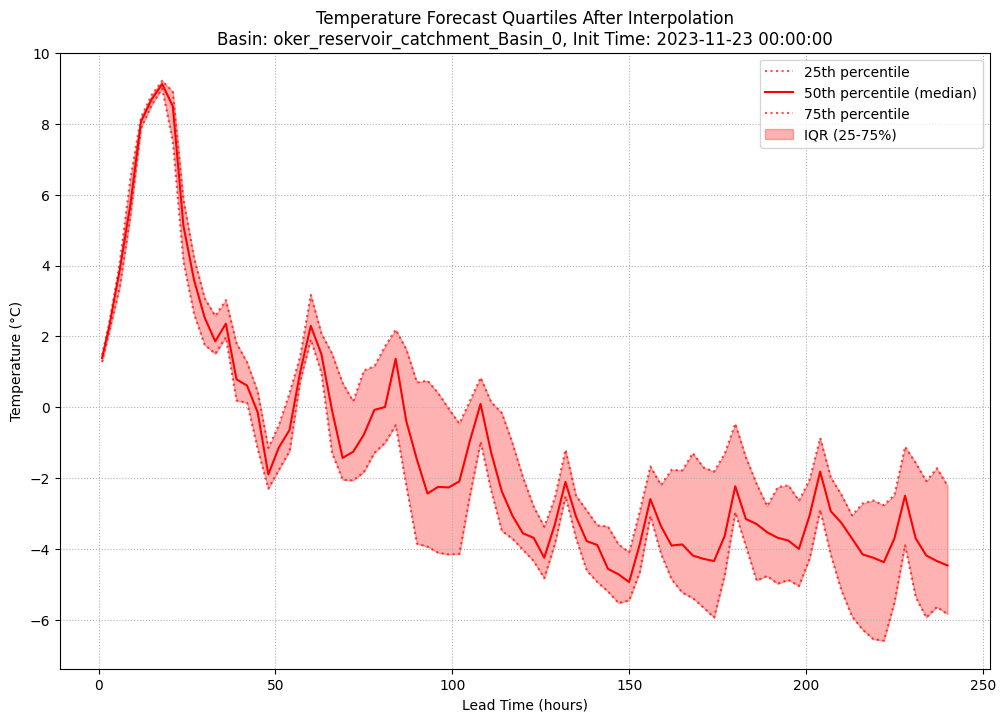

In [23]:
# Select a specific forecast initialization time and basin
forecast_init_time = '2023-11-23 00:00:00'
selected_basin = 'oker_reservoir_catchment_Basin_0'

# Extract the forecast dataset for the selected basin and initialization time
plot_ds = basin_forecasts_quartiles_hourly.sel(init_time=forecast_init_time, basin=selected_basin)

# Convert lead_time from integer hours to hours (already in hours for the hourly dataset)
lead_time_hours = plot_ds['lead_time'].values

# Plot the quartiles for temperature after interpolation
plt.figure(figsize=(12, 8))

# Plot the three temperature quartiles
plt.plot(lead_time_hours, plot_ds['temperature_2m_q25'], label='25th percentile', linestyle=':', alpha=0.7, color='red')
plt.plot(lead_time_hours, plot_ds['temperature_2m_q50'], label='50th percentile (median)', linestyle='-', color='red')
plt.plot(lead_time_hours, plot_ds['temperature_2m_q75'], label='75th percentile', linestyle=':', alpha=0.7, color='red')

# Fill between 25th and 75th percentiles
plt.fill_between(lead_time_hours, plot_ds['temperature_2m_q25'], plot_ds['temperature_2m_q75'], alpha=0.3, color='red', label='IQR (25-75%)')

plt.title(f'Temperature Forecast Quartiles After Interpolation\nBasin: {selected_basin}, Init Time: {forecast_init_time}')
plt.xlabel('Lead Time (hours)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True, linestyle=':')
plt.show()

## Fetch Historical Data

Fetch historical weather data from Open-Meteo for the same basins. The time range will match the forecast initialization times to ensure alignment.

In [24]:
# Determine the date range from the forecast data
start_date_hist = pd.to_datetime(basin_forecasts_quartiles.init_time.min().values).strftime('%Y-%m-%d')
end_date_hist = pd.to_datetime(basin_forecasts_quartiles.init_time.max().values).strftime('%Y-%m-%d')
print(f"Historical data range determined by forecast init_times: {start_date_hist} to {end_date_hist}")

# Define historical variables (can customize)
historical_variables = [
    "temperature_2m", "relative_humidity_2m", "precipitation", "rain", "snowfall", 
    "soil_moisture_0_to_7cm", "soil_moisture_7_to_28cm", "soil_moisture_28_to_100cm", 
    "soil_moisture_100_to_255cm", "et0_fao_evapotranspiration", "surface_pressure", 
    "snow_depth_water_equivalent"
]

# Fetch historical data
basin_historical_data = fetch_historical_for_basins(centroids, start_date_hist, end_date_hist, historical_variables)

# Display historical data summary
if basin_historical_data:
    display(basin_historical_data)
else:
    print("Failed to fetch historical data.")

Historical data range determined by forecast init_times: 2020-10-01 to 2025-05-27
Fetching historical data from 2020-10-01 to 2025-05-27 for 5 basins...
  Fetching data for: innerste_reservoir_catchment_Basin_0 (Lat: 51.8345, Lon: 10.3078)
  Fetching data for: oker_reservoir_catchment_Basin_0 (Lat: 51.8165, Lon: 10.4473)
  Fetching data for: ecker_reservoir_catchment_Basin_0 (Lat: 51.8101, Lon: 10.5841)
  Fetching data for: oker_reservoir_catchment_Basin_0 (Lat: 51.8165, Lon: 10.4473)
  Fetching data for: ecker_reservoir_catchment_Basin_0 (Lat: 51.8101, Lon: 10.5841)
  Fetching data for: soese_reservoir_catchment_Basin_0 (Lat: 51.7523, Lon: 10.3832)
  Fetching data for: soese_reservoir_catchment_Basin_0 (Lat: 51.7523, Lon: 10.3832)
  Fetching data for: grane_reservoir_catchment_Basin_0 (Lat: 51.8844, Lon: 10.3572)
  Fetching data for: grane_reservoir_catchment_Basin_0 (Lat: 51.8844, Lon: 10.3572)
Successfully fetched and combined historical data for 5 basins.
Historical Dataset dimensi

<xarray.Dataset> Size: 10MB
Dimensions:                      (basin: 5, time: 40800)
Coordinates:
  * time                         (time) datetime64[ns] 326kB 2020-10-01 ... 2...
  * basin                        (basin) <U36 720B 'innerste_reservoir_catchm...
Data variables:
    temperature_2m               (basin, time) float32 816kB 10.82 10.27 ... nan
    relative_humidity_2m         (basin, time) float32 816kB 92.3 91.96 ... nan
    precipitation                (basin, time) float32 816kB 0.0 0.0 ... nan nan
    rain                         (basin, time) float32 816kB 0.0 0.0 ... nan nan
    snowfall                     (basin, time) float32 816kB 0.0 0.0 ... nan nan
    soil_moisture_0_to_7cm       (basin, time) float32 816kB 0.356 0.356 ... nan
    soil_moisture_7_to_28cm      (basin, time) float32 816kB 0.349 0.349 ... nan
    soil_moisture_28_to_100cm    (basin, time) float32 816kB 0.307 0.307 ... nan
    soil_moisture_100_to_255cm   (basin, time) float32 816kB 0.352 0.352 ... nan
    et0_fao_evapotranspiration   (basin, time) float32 816kB 0.0 0.0 ... nan nan
    surface_pressure             (basin, time) float32 816kB 953.2 952.8 ... nan
    snow_depth_water_equivalent  (basin, time) float32 816kB nan nan ... nan nan
Attributes:
    latitude:               51.845340728759766
    longitude:              10.365631103515625
    elevation:              495.0
    timezone:               None
    timezone_abbreviation:  None
    utc_offset_seconds:     0
    api_source:             https://archive-api.open-meteo.com/v1/archive
    api_model:              best_match

## Merge Historical and Forecast Quartile Data

Combine the fetched historical data and the interpolated hourly forecast quartile data into a single xarray Dataset. The forecast `init_time` coordinate is renamed to `time` to align with the historical data.

The final dataset will have:
- Historical variables with dimensions ('basin', 'time')
- Forecast quartile variables with dimensions ('basin', 'time', 'lead_time')

In [25]:
# Rename 'init_time' in forecast data to 'time' for merging
basin_forecasts_quartiles_hourly_renamed = basin_forecasts_quartiles_hourly.rename({'init_time': 'time'})

# --- Add chunking for historical data ---
if basin_historical_data is not None:
    print("Chunking historical data...")
    basin_historical_data = basin_historical_data.chunk({'time': 'auto', 'basin': 'auto'})
    print("Historical data chunked.")
    # Display chunking info for a sample variable
    if 'temperature_2m' in basin_historical_data:
        print(f"Sample historical variable chunks ('temperature_2m'): {basin_historical_data['temperature_2m'].chunksizes}")
    elif basin_historical_data.data_vars:
        first_var = list(basin_historical_data.data_vars)[0]
        print(f"Sample historical variable chunks ('{first_var}'): {basin_historical_data[first_var].chunksizes}")
# --- End of added chunking ---

# Identify conflicting variable names (present in both historical and forecast)
# Note: With quartile suffixes, there should be fewer conflicts
conflicting_vars = []
if basin_historical_data is not None:
    # Check for conflicts with base variable names (before quartile suffixes)
    forecast_base_vars = set()
    for var in basin_forecasts_quartiles_hourly_renamed.data_vars:
        # Extract base variable name (remove quartile suffix)
        if var.endswith(('_q25', '_q50', '_q75')):
            base_var = var.rsplit('_q', 1)[0]
            forecast_base_vars.add(base_var)
    
    conflicting_vars = [var for var in basin_historical_data.data_vars if var in forecast_base_vars]

# Rename conflicting variables in the historical dataset
rename_dict = {var: f"{var}_hist" for var in conflicting_vars}
basin_historical_data_renamed = basin_historical_data.rename(rename_dict) if basin_historical_data is not None else None
if rename_dict:
    print(f"Renamed conflicting historical variables: {list(rename_dict.values())}")

# Merge the full historical and forecast datasets using 'no_conflicts'
print("Merging full historical and forecast quartile datasets...")
if basin_historical_data_renamed is not None:
    try:
        basin_forecast_historical_hourly = xr.merge([basin_historical_data_renamed, basin_forecasts_quartiles_hourly_renamed], compat='no_conflicts')
        print("\nMerge successful.")
        print(f"Combined Dataset dimensions: {dict(basin_forecast_historical_hourly.dims)}")
        
        # Separate variables by their dimensions for display
        historical_vars = []
        forecast_vars = []
        
        for var_name in basin_forecast_historical_hourly.data_vars:
            var_dims = basin_forecast_historical_hourly[var_name].dims
            if 'lead_time' in var_dims:
                forecast_vars.append(f"{var_name}: {var_dims}")
            else:
                historical_vars.append(f"{var_name}: {var_dims}")
        
        print(f"\nHistorical variables (basin, time): {len(historical_vars)}")
        for var in historical_vars[:5]:  # Show first 5
            print(f"  - {var}")
        if len(historical_vars) > 5:
            print(f"  ... and {len(historical_vars) - 5} more")
        
        print(f"\nForecast variables (basin, time, lead_time): {len(forecast_vars)}")
        for var in forecast_vars[:5]:  # Show first 5
            print(f"  - {var}")
        if len(forecast_vars) > 5:
            print(f"  ... and {len(forecast_vars) - 5} more")
        
        display(basin_forecast_historical_hourly)
    except Exception as e:
        print(f"\nMerge failed: {e}")
        # Fallback or further error handling
        basin_forecast_historical_hourly = None
else:
    print("Skipping merge as historical data failed to load or was not renamed.")
    basin_forecast_historical_hourly = basin_forecasts_quartiles_hourly_renamed 
    print("Proceeding with only forecast quartile data.")

Chunking historical data...
Historical data chunked.
Sample historical variable chunks ('temperature_2m'): Frozen({'basin': (5,), 'time': (40800,)})
Renamed conflicting historical variables: ['temperature_2m_hist', 'relative_humidity_2m_hist']
Merging full historical and forecast quartile datasets...

Merge successful.
Combined Dataset dimensions: {'time': 40800, 'basin': 5, 'lead_time': 240}

Historical variables (basin, time): 12
  - temperature_2m_hist: ('basin', 'time')
  - relative_humidity_2m_hist: ('basin', 'time')
  - precipitation: ('basin', 'time')
  - rain: ('basin', 'time')
  - snowfall: ('basin', 'time')
  ... and 7 more

Forecast variables (basin, time, lead_time): 63
  - categorical_freezing_rain_surface_q25: ('basin', 'time', 'lead_time')
  - categorical_freezing_rain_surface_q50: ('basin', 'time', 'lead_time')
  - categorical_freezing_rain_surface_q75: ('basin', 'time', 'lead_time')
  - categorical_ice_pellets_surface_q25: ('basin', 'time', 'lead_time')
  - categorical

<xarray.Dataset> Size: 25GB
Dimensions:                                         (time: 40800, basin: 5,
                                                     lead_time: 240)
Coordinates:
  * time                                            (time) datetime64[ns] 326kB ...
  * basin                                           (basin) <U36 720B 'inners...
  * lead_time                                       (lead_time) int64 2kB 1 ....
    expected_forecast_length                        (time) timedelta64[ns] 326kB dask.array<chunksize=(1700,), meta=np.ndarray>
    latitude                                        (basin) float64 40B 51.75...
    longitude                                       (basin) float64 40B 10.25...
    spatial_ref                                     int64 8B ...
Data variables: (12/75)
    temperature_2m_hist                             (basin, time) float32 816kB dask.array<chunksize=(5, 40800), meta=np.ndarray>
    relative_humidity_2m_hist                       (basin, time) float32 816kB dask.array<chunksize=(5, 40800), meta=np.ndarray>
    precipitation                                   (basin, time) float32 816kB dask.array<chunksize=(5, 40800), meta=np.ndarray>
    rain                                            (basin, time) float32 816kB dask.array<chunksize=(5, 40800), meta=np.ndarray>
    snowfall                                        (basin, time) float32 816kB dask.array<chunksize=(5, 40800), meta=np.ndarray>
    soil_moisture_0_to_7cm                          (basin, time) float32 816kB dask.array<chunksize=(5, 40800), meta=np.ndarray>
    ...                                              ...
    wind_v_100m_q25                                 (basin, time, lead_time) float64 392MB dask.array<chunksize=(1, 1, 240), meta=np.ndarray>
    wind_v_100m_q50                                 (basin, time, lead_time) float64 392MB dask.array<chunksize=(1, 1, 240), meta=np.ndarray>
    wind_v_100m_q75                                 (basin, time, lead_time) float64 392MB dask.array<chunksize=(1, 1, 240), meta=np.ndarray>
    wind_v_10m_q25                                  (basin, time, lead_time) float64 392MB dask.array<chunksize=(1, 1, 240), meta=np.ndarray>
    wind_v_10m_q50                                  (basin, time, lead_time) float64 392MB dask.array<chunksize=(1, 1, 240), meta=np.ndarray>
    wind_v_10m_q75                                  (basin, time, lead_time) float64 392MB dask.array<chunksize=(1, 1, 240), meta=np.ndarray>
Attributes:
    latitude:               51.845340728759766
    longitude:              10.365631103515625
    elevation:              495.0
    timezone:               None
    timezone_abbreviation:  None
    utc_offset_seconds:     0
    api_source:             https://archive-api.open-meteo.com/v1/archive
    api_model:              best_match

## Visualize Combined Historical and Forecast Quartile Data

Plot the historical data for the two weeks leading up to the latest forecast initialization time, followed by the forecast quartiles (25th, 50th, 75th percentiles) for temperature and precipitation.

Targeting plot around Christmas 2023 Forecast Initialization Time (UTC): 2023-12-23 00:00:00
Using Initialization Time for Plotting (UTC): 2023-12-23 00:00:00
Preparing plot for basin: oker_reservoir_catchment_Basin_0
Historical data window for plot (UTC): 2023-12-16 00:00 to 2023-12-23 00:00:00
Historical data window for plot (UTC): 2023-12-16 00:00 to 2023-12-23 00:00:00
Successfully selected historical slice for plot (Range: 2023-12-16T00:00:00.000000000 to 2023-12-23T00:00:00.000000000)
Successfully selected forecast data for plot (Init time: 2023-12-23T00:00:00.000000000)
Loading data slices into memory for plotting...
Successfully selected historical slice for plot (Range: 2023-12-16T00:00:00.000000000 to 2023-12-23T00:00:00.000000000)
Successfully selected forecast data for plot (Init time: 2023-12-23T00:00:00.000000000)
Loading data slices into memory for plotting...
Finished loading data slices.
Plotting 169 valid historical temperature points.
Plotting 169 valid historical pr

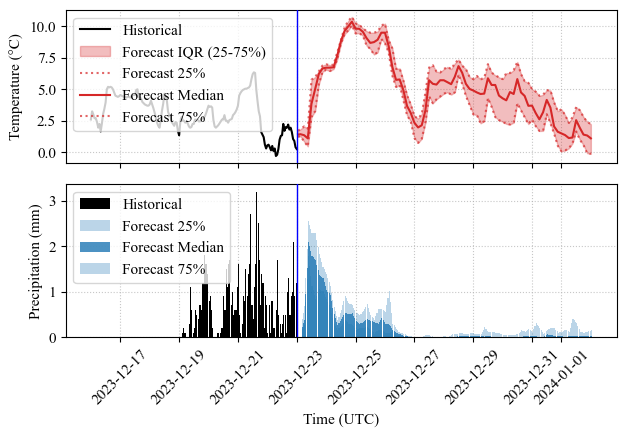

In [26]:
# --- Visualization Configuration ---

# --- Figure and Font Size ---
FIG_WIDTH = 6.4
FIG_HEIGHT = 5
FONT_SIZE = 11

selected_basin = basin_forecast_historical_hourly['basin'].values[1] # Select Oker reservoir catchment for plotting
historical_days = 7 # Days of historical data before the forecast start

# Variable names (adjust for new quartile naming convention)
historical_temp_var = 'temperature_2m_hist'
historical_precip_var = 'precipitation' # Assuming Open-Meteo provides hourly precipitation (mm)
forecast_temp_vars = {
    'q25': 'temperature_2m_q25',
    'q50': 'temperature_2m_q50',
    'q75': 'temperature_2m_q75'
}
forecast_precip_vars = {
    'q25': 'precipitation_surface_q25',
    'q50': 'precipitation_surface_q50',
    'q75': 'precipitation_surface_q75'
}

# Conversion factor for precipitation: mm/s to mm/hr
MM_PER_S_TO_MM_PER_HR = 3600

# --- Define Specific Time for Plotting (e.g., Christmas 2023) ---
plot_forecast_init_time = None
if 'basin_forecast_historical_hourly' in locals() and basin_forecast_historical_hourly is not None:
    christmas_2023_target_time = pd.Timestamp('2023-12-23 00:00:00')
    print(f"Targeting plot around Christmas 2023 Forecast Initialization Time (UTC): {christmas_2023_target_time.strftime('%Y-%m-%d %H:%M:%S')}")
    
    # Find the closest available initialization time in the *merged* dataset
    available_times = pd.to_datetime(basin_forecast_historical_hourly.time.values)
    if christmas_2023_target_time in available_times:
        plot_forecast_init_time = christmas_2023_target_time
    else:
        time_diffs = np.abs(available_times - christmas_2023_target_time)
        closest_idx = time_diffs.argmin()
        plot_forecast_init_time = available_times[closest_idx]
        print(f"Exact Christmas date not found in data, using closest available init time for plotting: {plot_forecast_init_time.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Using Initialization Time for Plotting (UTC): {plot_forecast_init_time.strftime('%Y-%m-%d %H:%M:%S')}")
else:
     print("Merged dataset not available to determine plot initialization time.")

# --- Data Preparation for Plotting ---
plot_data_available = False
historical_temp_data = None
historical_precip_data = None
forecast_temp_data = {}
forecast_precip_data = {}
forecast_time_axis = None

# Proceed only if merged data and a plot time are available
if 'basin_forecast_historical_hourly' in locals() and basin_forecast_historical_hourly is not None and plot_forecast_init_time is not None:
    print(f"Preparing plot for basin: {selected_basin}")

    # Select data for the chosen basin
    basin_data = basin_forecast_historical_hourly.sel(basin=selected_basin)

    # Define time windows relative to the *plot* initialization time
    hist_end_time = plot_forecast_init_time
    hist_start_time = hist_end_time - timedelta(days=historical_days)
    print(f"Historical data window for plot (UTC): {hist_start_time.strftime('%Y-%m-%d %H:%M')} to {hist_end_time.strftime('%Y-%m-%d %H:%M:%S')}")

    # Extract historical and forecast slices based on plot_forecast_init_time
    try:
        # Slice historical data up to the plot init time
        historical_slice = basin_data.sel(time=slice(hist_start_time, hist_end_time))
        # Select the specific forecast initialized at plot_forecast_init_time
        latest_forecast = basin_data.sel(time=plot_forecast_init_time)
        print(f"Successfully selected historical slice for plot (Range: {historical_slice.time.min().values} to {historical_slice.time.max().values})")
        print(f"Successfully selected forecast data for plot (Init time: {latest_forecast.time.values})")
        plot_data_available = True
    except KeyError as e:
        print(f"Error selecting data slices for plot: {e}. Check time coordinates ({plot_forecast_init_time}) and availability.")
    except Exception as e:
        print(f"An unexpected error occurred during data selection for plot: {e}")

    if plot_data_available:
        # Extract specific variables if slices are valid
        # --- Load data into memory before plotting ---
        print("Loading data slices into memory for plotting...")
        try:
            # Historical Data
            if historical_temp_var in historical_slice:
                historical_temp_data = historical_slice[historical_temp_var].compute() # Load historical temp
                if historical_temp_data.isnull().all():
                    print(f"Warning: Historical temperature ('{historical_temp_var}') for plot is all NaN.")
            else:
                print(f"Warning: Historical temperature variable '{historical_temp_var}' not found for plot.")

            if historical_precip_var in historical_slice:
                historical_precip_data = historical_slice[historical_precip_var].compute() # Load historical precip
                if historical_precip_data.isnull().all():
                    print(f"Warning: Historical precipitation ('{historical_precip_var}') for plot is all NaN.")
            else:
                print(f"Warning: Historical precipitation variable '{historical_precip_var}' not found for plot.")

            # Forecast Quartile Data - Temperature
            for quartile, var_name in forecast_temp_vars.items():
                if var_name in latest_forecast:
                    forecast_temp_data[quartile] = latest_forecast[var_name].compute()
                else:
                    print(f"Warning: Forecast temperature variable '{var_name}' not found for plot.")

            # Forecast Quartile Data - Precipitation
            for quartile, var_name in forecast_precip_vars.items():
                if var_name in latest_forecast:
                    forecast_precip_data[quartile] = latest_forecast[var_name].compute()
                else:
                    print(f"Warning: Forecast precipitation variable '{var_name}' not found for plot.")

            # Calculate forecast time axis relative to plot_forecast_init_time
            forecast_lead_hours = latest_forecast['lead_time'].values
            forecast_time_axis = plot_forecast_init_time + pd.to_timedelta(forecast_lead_hours, unit='h')
            print("Finished loading data slices.")
            # --- End loading data ---

        except Exception as e:
            print(f"Error extracting or loading variables for plotting: {e}")
            import traceback
            traceback.print_exc()
            plot_data_available = False # Prevent plotting if extraction fails
else:
    print("Combined dataset 'basin_forecast_historical_hourly' or 'plot_forecast_init_time' not found/determined. Cannot prepare plot data.")

# --- Create Plot ---
if plot_data_available:
    # Set the default font and size
    plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Times New Roman'],
        'font.size': FONT_SIZE
    })
    
    fig, axes = plt.subplots(2, 1, figsize=(FIG_WIDTH, FIG_HEIGHT), sharex=True)

    # --- Temperature Plot (ax1) ---
    ax1 = axes[0]
    temp_units = '°C'
    if forecast_temp_data.get('q50') is not None:
        temp_units = forecast_temp_data['q50'].attrs.get('units', '°C')

    # Plot Historical Temperature
    if historical_temp_data is not None and not historical_temp_data.isnull().all():
        valid_historical_temp = historical_temp_data.dropna(dim='time')
        if valid_historical_temp.size > 0:
            ax1.plot(valid_historical_temp['time'].values, valid_historical_temp.values,
                     label=f'Historical', color='black', linewidth=1.5, zorder=5)
            print(f"Plotting {valid_historical_temp.size} valid historical temperature points.")
        else:
            print("No valid historical temperature points to plot after dropping NaNs.")

    # Plot Forecast Temperature Quartiles
    if forecast_temp_data and forecast_time_axis is not None:
        # Plot quartile band (25th to 75th percentile)
        if 'q25' in forecast_temp_data and 'q75' in forecast_temp_data:
            ax1.fill_between(forecast_time_axis,
                             forecast_temp_data['q25'].values,
                             forecast_temp_data['q75'].values,
                             color='#d62728', alpha=0.3, label='Forecast IQR (25-75%)', zorder=2)
        
        # Plot individual quartile lines
        quartile_styles = {'q25': ':', 'q50': '-', 'q75': ':'}
        quartile_alphas = {'q25': 0.7, 'q50': 1.0, 'q75': 0.7}
        quartile_labels = {'q25': 'Forecast 25%', 'q50': 'Forecast Median', 'q75': 'Forecast 75%'}
        
        for quartile, data in forecast_temp_data.items():
            ax1.plot(forecast_time_axis, data.values,
                     label=quartile_labels[quartile], color='#d62728', 
                     linestyle=quartile_styles[quartile], alpha=quartile_alphas[quartile], zorder=3)

    ax1.set_ylabel(f"Temperature ({temp_units})")
    ax1.legend(loc='upper left')
    ax1.grid(True, linestyle=':', alpha=0.7)
    ax1.axvline(plot_forecast_init_time, color='blue', linestyle='-', linewidth=1, label='Forecast Start', zorder=6)

    # --- Precipitation Plot (ax2) ---
    ax2 = axes[1]
    precip_units_hist = 'mm'
    precip_units_fcst = 'mm'
    forecast_bar_width_days = (forecast_time_axis[1] - forecast_time_axis[0]) / np.timedelta64(1, 'D') if len(forecast_time_axis) > 1 else 1/24

    # Plot Historical Precipitation (Bars)
    if historical_precip_data is not None and not historical_precip_data.isnull().all():
        valid_historical_precip = historical_precip_data.dropna(dim='time')
        if valid_historical_precip.size > 0:
            hist_time_diff = np.diff(valid_historical_precip['time'].values)
            hist_bar_width_days = (hist_time_diff[0] / np.timedelta64(1, 'D')) if len(hist_time_diff) > 0 else (1/24)
            ax2.bar(valid_historical_precip['time'].values, valid_historical_precip.values,
                    width=hist_bar_width_days * 0.9, label=f'Historical', color='black', align='edge', zorder=3)
            print(f"Plotting {valid_historical_precip.size} valid historical precipitation points.")
        else:
            print("No valid historical precipitation points to plot after dropping NaNs.")

    # Plot Forecast Precipitation Quartiles
    if forecast_precip_data and forecast_time_axis is not None:
        quartile_alphas = {'q25': 0.3, 'q50': 0.8, 'q75': 0.3}
        quartile_labels = {'q25': 'Forecast 25%', 'q50': 'Forecast Median', 'q75': 'Forecast 75%'}
        
        for quartile, data in forecast_precip_data.items():
            forecast_precip_mmhr = data.values * MM_PER_S_TO_MM_PER_HR
            ax2.bar(forecast_time_axis, forecast_precip_mmhr,
                    width=forecast_bar_width_days * 0.9, label=quartile_labels[quartile], 
                    color='#1f77b4', alpha=quartile_alphas[quartile], align='edge', zorder=2)

    ax2.set_ylabel(f"Precipitation ({precip_units_fcst})")
    ax2.legend(loc='upper left')
    ax2.grid(True, linestyle=':', alpha=0.7)
    ax2.axvline(plot_forecast_init_time, color='blue', linestyle='-', linewidth=1, zorder=4)

    # --- Final Formatting ---
    plt.xlabel("Time (UTC)")
    plt.xticks(rotation=45)
    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    
    # --- Save Plot (BEFORE plt.show()) ---
    plot_filename = os.path.join(output_dir, f"forecast_quartiles_plot_{selected_basin}_{plot_forecast_init_time.strftime('%Y%m%d_%H%M')}.pdf")
    try:
        fig.savefig(plot_filename, format='pdf', bbox_inches='tight', dpi=300)
        print(f"Plot saved to {plot_filename}")
    except Exception as e:
        print(f"Error saving plot: {e}")
        
    # --- Show Plot ---
    plt.show()
else:
    print("Skipping plot generation because necessary data could not be prepared.")